# Ненужные вещи

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи".
В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Цель исследования- Ответить на вопросы заказчика:

1. Какие пользователи склонны часто возвращаться в мобильное приложение?
2. Какие пользователи часто делают целевое событие (contacts_show)
3. Как различается время между распространенными событиями пользователей, (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

In [ ]:
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [ ]:
mobile_sourсes, mobile_dataset = pd.read_csv(
    'https://datasets/mobile_soures.csv'
    ), pd.read_csv('https://datasets/mobile_dataset.csv')

## 1. Предобработка данных

### 1.1 Изучение общей информации.

In [ ]:
for datasets in mobile_sourсes, mobile_dataset:
    datasets.info()
    print('duplicated sum:', datasets.duplicated().sum())
    print('--------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
duplicated sum: 0
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
duplicated sum: 0
--------------------------------------


Видим неудобные названия колонок в датафреймах. Приведем их в змеиный регистр.

### 1.2 Приведение данных к соответствующему типу.

In [ ]:
mobile_sourсes.rename(columns={
    'userId':'user_id'
    }, inplace=True)

mobile_dataset.rename(columns={
    'user.id':'user_id',
    'event.time':'event_time',
    'event.name':'event_name'
    }, inplace=True)

mobile_dataset['event_time'] = pd.to_datetime(
    mobile_dataset['event_time'], format='%Y.%m.%d %H:%M:%S'
    ).dt.round('1S')

mobile_dataset['event_name'].replace(
    'show_contacts', 'contacts_show', inplace=True
    )
mobile_dataset.drop_duplicates(inplace=True)
mobile_dataset.reset_index(drop=True, inplace=True)

## 2. Исследовательский анализ

In [ ]:
print('total users:', mobile_dataset['user_id'].nunique())

total users: 4293


Общее количество пользователей в датафрейме - 4293


In [ ]:
print('date start:', mobile_dataset['event_time'].min())
print('date end:',mobile_dataset['event_time'].max())

date start: 2019-10-07 00:00:00
date end: 2019-11-03 23:58:13


Данные в датафрейме начинаются с 2019-10-07 00:00:00 и заканчиваются 2019-11-03 23:58:13

In [ ]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id')

df.groupby('source')['user_id'].nunique()

source
google    1129
other     1230
yandex    1934
Name: user_id, dtype: int64

Так пользователи распределены по источникам

### 2.1 Создание пользовательских ссесий.

Выделим сессии с таймаутом в 30 минут

In [ ]:
df['session_id'] = df.groupby(['user_id',(
    df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')
    ).cumsum()], sort=False).ngroup() + 1

Посчитаем длительность сессий

In [ ]:
df = df.merge(
    (df.groupby('session_id')['event_time'].max() -
     df.groupby('session_id')['event_time'].min()
     ).dt.total_seconds().div(60).astype(int).reset_index(),
     on='session_id')

df.rename(columns={
    'event_time_x':'event_time',
    'event_time_y':'session_time'
    }, inplace=True)

Уберем слишком короткие и слишком длинные сессии, скорее всего это выборсы

In [ ]:
df = df.query(
    'session_time > session_time.quantile(0.05) and \
     session_time < session_time.quantile(0.95)'
     )

Посмотрим на длительность сесиий после фильтрации:

In [ ]:
print('session time', df['session_time'].min(), '-', df['session_time'].max())

session time 1 - 102


Посмотрим как на общее количество пользователей после фильтрации и как они \
распределены по источникам:

In [ ]:
print('total users:', df['user_id'].nunique())
df.groupby('source')['user_id'].nunique()

total users: 4024


source
google    1079
other     1116
yandex    1829
Name: user_id, dtype: int64

## 3. Выделение пользователей на группы на основе их действий

Преобразуем датафрейм:

In [ ]:
df_dummies = pd.get_dummies(data=df, columns=['event_name', 'source'])

In [ ]:
df_dummies = df_dummies.groupby('user_id').mean().drop(['session_id'], axis=1)

df_dummies = df_dummies.merge(
    df.groupby('user_id')['session_id'].count(), on='user_id'
    ).rename(columns={'session_id': 'session_count'})

In [ ]:
df_dummies

,session_time,event_name_advert_open,event_name_contacts_call,event_name_contacts_show,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,session_count
user_id,,,,,,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11.571429,0.000000,0.000000,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.828571,0.0,1.0,0.0,35
00157779-810c-4498-9e05-a1e9e3cedf93,45.585714,0.028571,0.071429,0.142857,0.028571,0.000000,0.471429,0.257143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,70
00463033-5717-4bf1-91b4-09183923b9df,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,10
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,26.000000,0.178571,0.000000,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.035714,0.035714,0.178571,0.035714,0.178571,0.000000,0.142857,1.0,0.0,0.0,28
00551e79-152e-4441-9cf7-565d7eb04090,9.000000,0.000000,0.400000,0.400000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff82c7c7-16d6-44b1-833b-a217747b0b02,33.215686,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.000000,0.058824,0.058824,0.039216,0.000000,0.019608,0.705882,0.0,0.0,1.0,51
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,25.294118,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.882353,0.0,0.0,1.0,17
ffcf50d9-293c-4254-8243-4890b030b238,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.0,0.0,0.0,2


Стандартизируем данные

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(df_dummies)

In [ ]:
linked = linkage(X_sc, method='ward')

Отрисуем класстеры

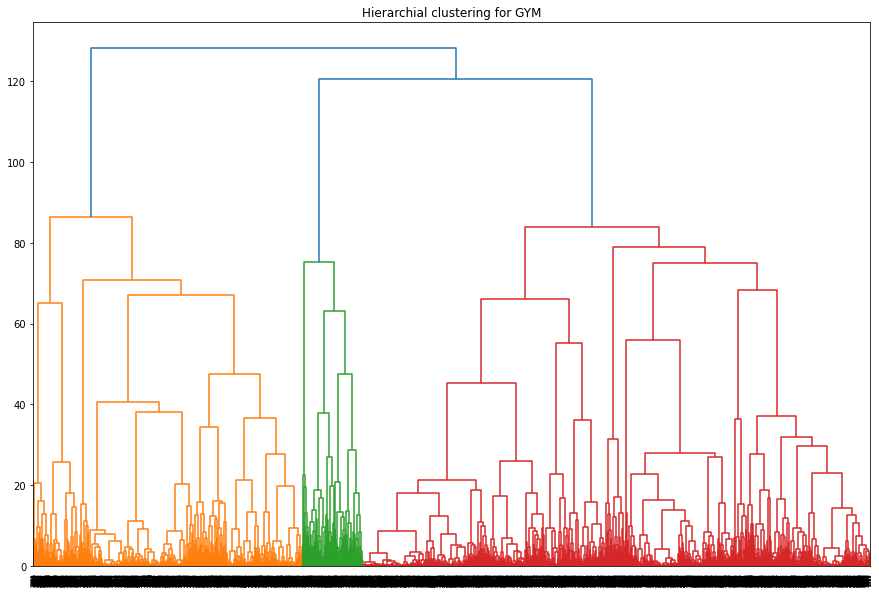

In [ ]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Выделим 3 классетера на основе графика

In [ ]:
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(X_sc)
df_dummies['labels'] = labels

In [ ]:
df = df.merge(df_dummies['labels'].reset_index(), on='user_id')

Посмотрим как пользователи распределились по группам

In [ ]:
df.groupby('labels')['user_id'].nunique()

labels
0     316
1    2475
2    1233
Name: user_id, dtype: int64

In [ ]:
X_sc = pd.DataFrame(data=X_sc, columns=df_dummies.drop('labels', axis=1).columns)

In [ ]:
X_sc['labels'] = df_dummies.reset_index()['labels']

/tmp/ipykernel_48/1969269695.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


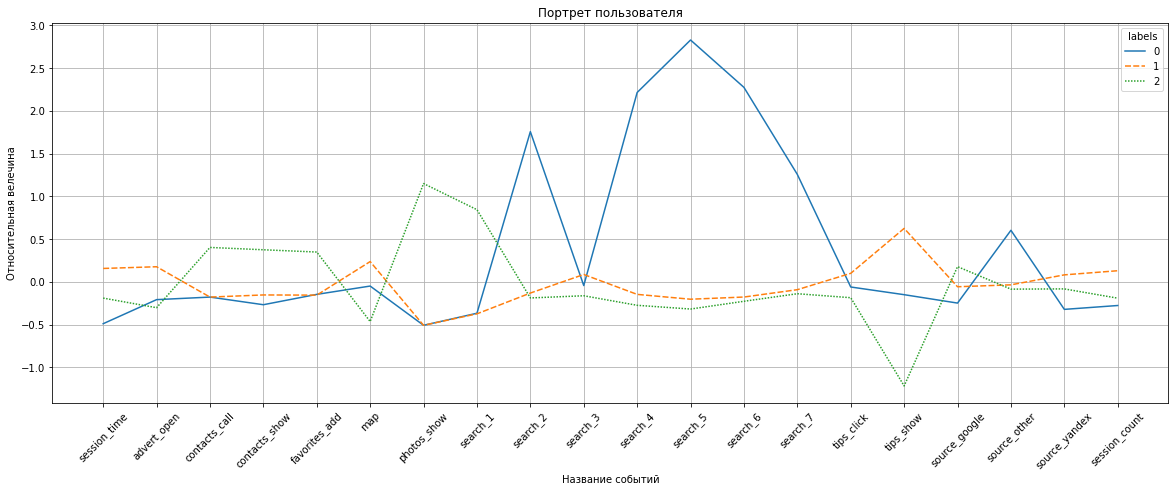

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.lineplot(data=X_sc.groupby('labels').mean().T)
ax.set_xticklabels(
    [i.replace('event_name_', '') for i in df_dummies.columns],
    fontsize = 10,
    rotation = 45
)
plt.title('Портрет пользователя')
plt.xlabel('Название событий')
plt.ylabel('Относительная велечина')
ax.grid(True)
plt.show()


Пользователям из 2 группы отностительно других групп меньше всего/не показывали рекомендованные объясвления. <br>
Пользователи из 2 группы предпочитают листать фото карточек.<br>
Пользователи из группы 0 часто пользуются поиском, видимо не находят в поиске того, чего искали. <br>
Пользователи из группы 1 чаще проводят время в приложении, им часто показывают рекомндованные объявления. <br>

## 3. Ответы на вопросы заказчика


### 3.1 Какие пользователи склонны часто возвращаться в мобильное приложение?

Выделим профили пользователей

In [ ]:
profiles = df.sort_values(by=['user_id', 'event_time']).groupby('user_id').agg(
    {
        'event_time': 'first',
        'source': 'first',
        'labels': 'first'
        }).rename(columns={
            'source': 'channel'
            }).reset_index()

profiles['dt'] = profiles['event_time'].dt.date

Выделим сессии и время старта

In [ ]:
sessions = df.sort_values(
    by=['session_id', 'event_time']).groupby('session_id').agg(
    {
        'event_time': 'first',
        'user_id': 'first'
        }).rename(columns={
            'event_time': 'session_start'
            }).reset_index()
sessions['session_start'] = sessions['session_start'].dt.date
sessions = sessions.drop('session_id', axis=1)

In [ ]:
def get_retention(profiles,sessions,observation_date,horizon_days,dimensions=[],
                  ignore_horizon=False):

    dimensions = ['labels'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['dt']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
observation_date = datetime(2019, 11, 3).date()
horizon_days = 7

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days)

In [ ]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только labels,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'labels'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания  пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.droplevel('labels').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание  пользователей')

    # в третьей ячейке — динамика удержания
    ax3 = plt.subplot(2, 2, 2)

    # фильтруем данные и строим график
    filtered_data = retention_history.pivot_table(
        index='dt', columns='labels', values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

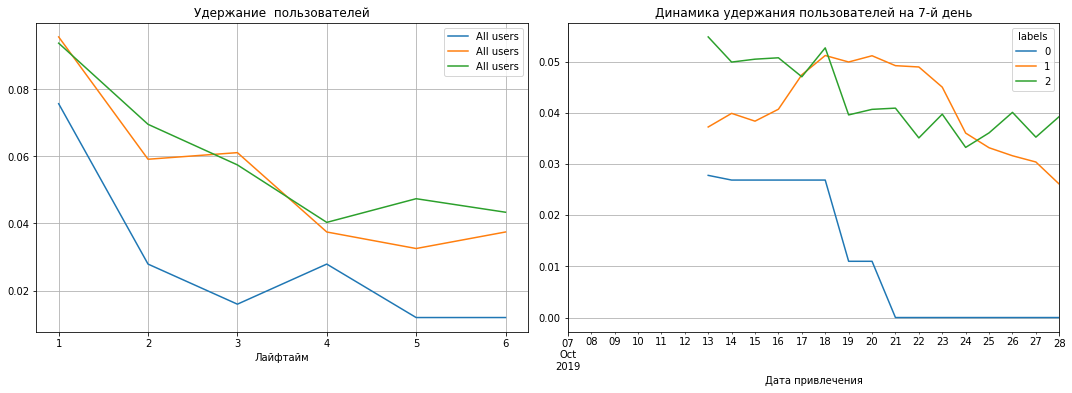

In [ ]:
plot_retention(retention_grouped, retention_history, horizon_days)

Лучше всего удерживаются пользователи из 2 группы

### 3.2 Какие пользователи часто делают целевое событие (contacts_show)

In [ ]:
action_frequency = pd.get_dummies(data=df, columns=['event_name'])
action_frequency = action_frequency.groupby('labels').sum().drop(
    ['session_id', 'session_time'], axis=1
    )
total = action_frequency.sum(axis=1)
for col in action_frequency.columns:
    action_frequency[col] = action_frequency[col] / total

/tmp/ipykernel_48/3835040905.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


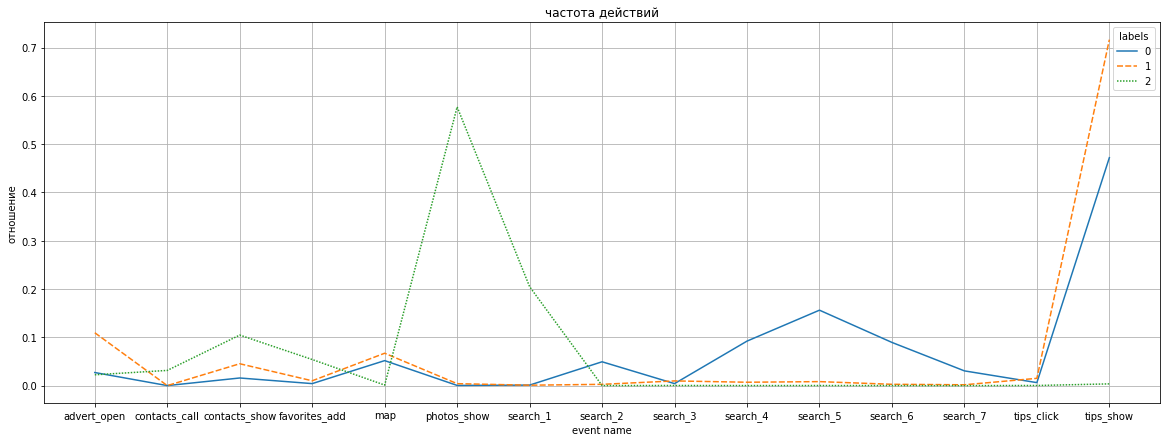

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.lineplot(data=action_frequency.T)
ax.set_xticklabels(
    [i.replace('event_name_', '') for i in action_frequency.columns]
    )
plt.title('частота действий')
plt.xlabel('event name')
plt.ylabel('отношение')
ax.grid(True)
plt.show()

Пользователи из 2 группы чаще всего делают целевое действие

### 3.3 Конверсия в просмотр контаков

In [ ]:
purchases = df.query('event_name == "contacts_show"')[['user_id', 'event_time',
                                                       'event_name']]
purchases = purchases.rename(columns={'event_time':'event_dt'})
purchases['event_dt'] = purchases['event_dt'].dt.date

In [ ]:
def get_conversion(profiles,purchases,observation_date,horizon_days,
                   dimensions=['labels'],ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['dt']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,purchases,observation_date,horizon_days
    )

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

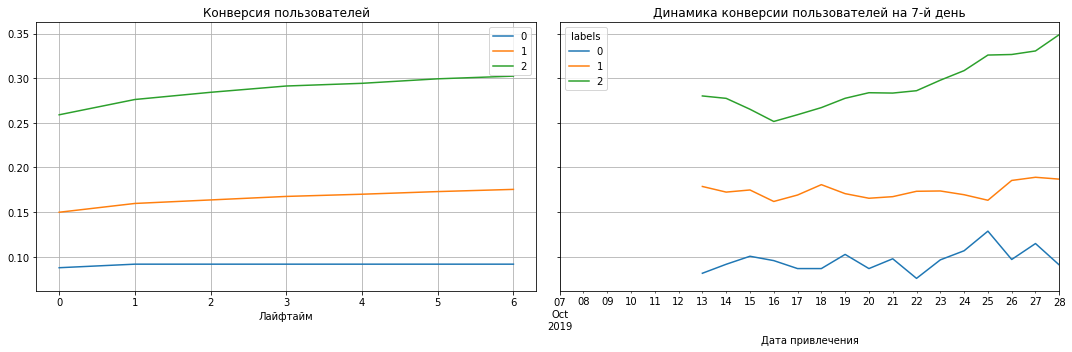

In [ ]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Самая высокая конверсия у 2 группы, на втором месте группа 1

### 3.3 Время между распространенными событиями

In [ ]:
df['event_name'].replace(
    ['search_1', 'search_2', 'search_3', 'search_4',
     'search_5', 'search_6', 'search_7'], 'search', inplace=True
    )


nwdf = df.merge(
    df.query('event_name == "search"').groupby('session_id').agg(
        {'event_time':'min'}).reset_index().rename(
            columns={'event_time':'time_contacts_show'}), on='session_id')

nwdf = nwdf.merge(
    df.groupby('session_id').agg(
        {'event_time':'min'}).reset_index().rename(
            columns={'event_time':'session_start'}), on='session_id')

nwdf['difference_in_time'] = (nwdf['time_contacts_show'] -
                            nwdf['session_start']
                            ).dt.total_seconds()

nwdf.groupby('labels')['difference_in_time'].mean()

labels
0     24.975081
1    310.638298
2    216.173682
Name: difference_in_time, dtype: float64

Пользователи из группы 0 быстрее всех начинают пользоваться поиском. <br>
Пользователи из группы 1 дольше всех доходят до поиска.

## 4. Проверка статистических гипотиз

In [ ]:
def z_test(trials, successes, event_name, alpha=.05):
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'{event_name} p-значение: {p_value}')

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными"
            )

### 4.1 Первая гипотиза
Некоторые пользователи установили приложение по ссылке из yandex, другие — из google.  \
Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

Нулевая гипотиза будет звучать так: доли двух генеральных совокупностей равны. \
Альтернативная гипотиза: доли двух генеральных совокупностей не равны.

In [ ]:
group_a = df.query('source == "yandex"')
group_b = df.query('source == "google"')

a_b_total = [group_a['user_id'].nunique(), group_b['user_id'].nunique()]

a_b_show = [group_a.query('event_name == "contacts_show"')['user_id'].nunique(),
            group_b.query('event_name == "contacts_show"')['user_id'].nunique()]

z_test(a_b_total, a_b_show, 'contacts_show')

contacts_show p-значение: 0.5324381707371875
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными


### 4.2 Вторая гипотиза

Проверим гипотезу о равенстве конверсии в просмотры контактов у пользователей, \
с длинной ссесией к пользователям с короткой сессией.

Нулевая гипотиза: конверсии двух групп равны. \
Альтернативная гипотиза: конверсии двух групп не равны.

In [ ]:
group_a = df.query('session_time > 50')
group_b = df.query('session_time < 50')

a_b_total = [group_a['user_id'].nunique(), group_b['user_id'].nunique()]

a_b_show = [group_a.query('event_name == "contacts_show"')['user_id'].nunique(),
            group_b.query('event_name == "contacts_show"')['user_id'].nunique()]

z_test(a_b_total, a_b_show, 'contacts_show')

contacts_show p-значение: 2.9323832251293425e-10
Отвергаем нулевую гипотезу: между долями есть значимая разница


Длинна сессий у нас от 1 до 102 минут.

## 5. Общий вывод:

1. Какие пользователи склонны часто возвращаться в мобильное приложение? - Вторая группа

2. Какие пользователи часто делают целевое событие (contacts_show) - Вторая группа

3. Как различается время между распространенными событиями пользователей,(например, различаются ли пользователи по группам на основе времени,которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

Пользователям из 2 группы отностительно других групп меньше всего/не показывали рекомендованные объясвления. <br>
Пользователи из 2 группы предпочитают листать фото карточек.<br>
Пользователи из группы 0 часто пользуются поиском, видимо не находят в поиске того, чего искали. <br>
Пользователи из группы 1 чаще проводят время в приложении, им часто показывают рекомндованные объявления. <br>

Скорее всего дело в рекомендациях системы. <br>
Советую проверить на сколько актуальные объявления показывают пользователям.